# Machine Learning 1 Random Forest Model

This code focuses on sampling data that can be used in the model building. As the data sets contain many rows, we use sampling to reduce size.

In [43]:
import pandas as pd
import os
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm



In [2]:
directory_path = 'C:/Users/sixte/University of Toronto/Antoine Pepin - Big Project/Data/Full Final DataFrames'

Using 1 % of data means we are still using over 2.7 million rows of data in the model training and validation.

Choose month and percentage to filter:

In [3]:
m = [6, 7, 8, 9] # We focus our model on the summer months, when there are the most fire occurrances.
p = 0.01

For train data

In [4]:
dataframes = []

for file_name in os.listdir(directory_path):
    if file_name.endswith('.parquet'):
        
        parts = file_name.split('_')
        year = int(parts[0])
        month = int(parts[1])

        if month in m and 2001 <= year <= 2018:
            file_path = os.path.join(directory_path, file_name)
            df = pd.read_parquet(file_path)
            
            # Perform random sampling (p share of the DataFrame)
            sample_size = int(p * len(df))
            random_sample = df.sample(n=sample_size, random_state=42)
            
            dataframes.append(random_sample)

Since there potentially is a trend over the years in the data (i.e. we are working with a time series), the test data is chosen as the last three of the 21 years. This is about 15 % of the data, locked away.

Same principle for test data.

In [5]:
testframes = []

for file_name in os.listdir(directory_path):
    if file_name.endswith('.parquet'):
        parts = file_name.split('_')
        year = int(parts[0])
        month = int(parts[1])

        if month in m and 2019 <= year <= 2021:
            file_path = os.path.join(directory_path, file_name)
            df = pd.read_parquet(file_path)
            
            # Perform random sampling (p share of the DataFrame)
            sample_size = int(p * len(df))
            random_sample = df.sample(n=sample_size, random_state=42)
            
            testframes.append(random_sample)

Concatenate all dataframes to one.

In [6]:
data = pd.concat(dataframes)
test = pd.concat(testframes)

In [7]:
print(len(data))

10889064


Columns that happen to have too many NaN values aren't suitable for a simple model like the one we are building. More analysis on these columns during the processing of the climate data could make it useful. They are, however, omitted from this model. (BS: Hours of bright sunshine, B%S: Hours of bright sunshine compared to normal values)

Some cleaning of the X values is needed in the feature engineering. NaN values are filled using the imputer tool from the SciKit-library. The age-generating function also happened to create some negative values. We'll just remove the rows affected.

In [49]:
def feature_engineering(data):

    # Change features here.
    feature_selected = ['age', 'vol', 'Tm', 'Tx', 'Tn', 'P'] 
    data = data[data['age'] >= 0]

    X = data[feature_selected]
    y = data['burned']

    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    return X, y


Split the dataset into training and validation.

In [50]:
X, y = feature_engineering(data)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

There are around 10^3 rows of 'burned' status being 0 for every row where 'burned' status is 1. The balance is taken in account for by using class_weights, making the model more sensitive to patterns in the status 1 class.

In [51]:
class_counts = y_train.value_counts()
class_weights = {0: 1, 1: class_counts[0] / class_counts[1]}

We select some hyperparameters for the model.

In [52]:
model = RandomForestClassifier(max_depth = 30, class_weight = class_weights) 


Fit the model to our data.

In [53]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 3200.901225399183}, max_depth=30)

Do a prediction using the validation set.

In [54]:
y_pred = model.predict(X_val)

And print the F1-score from tbe validation set.

In [55]:
print(f1_score(y_val, y_pred))

0.8920502092050209


# On to the test set

This final model is evaluated using the test set that was separated in the beginning.

In [56]:
X_test, y_test = feature_engineering(test)
y_test_pred = model.predict(X_test)

In [57]:
print(f1_score(y_test, y_test_pred))

0.8951423785594639


Generate Confusion Matrix.

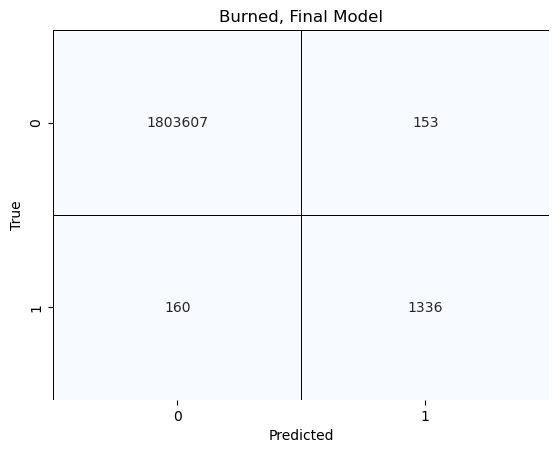

In [83]:
cm = confusion_matrix(y_test, y_test_pred)


sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", vmin=0.4, vmax=.4, cbar=False, linewidths=0.5, linecolor='black')
plt.title("Burned, Final Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig('Confusion Matrix')
plt.show()

A classification report

In [80]:
print(classification_report(y_test, y_test_pred,  digits=6))

              precision    recall  f1-score   support

         0.0   0.999911  0.999915  0.999913   1803760
         1.0   0.897246  0.893048  0.895142      1496

    accuracy                       0.999827   1805256
   macro avg   0.948579  0.946482  0.947528   1805256
weighted avg   0.999826  0.999827  0.999826   1805256



And a feature importance plot

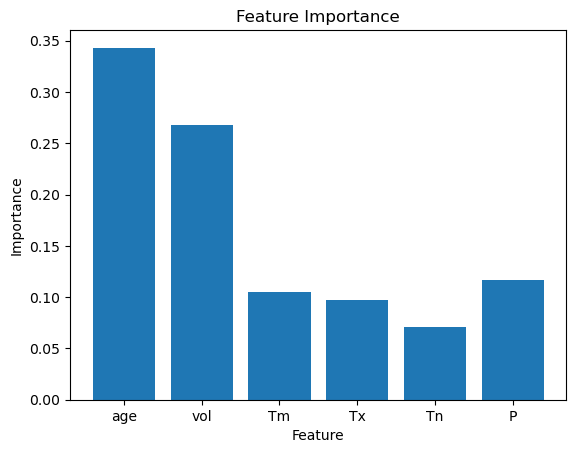

<Figure size 640x480 with 0 Axes>

In [84]:
if hasattr(model, 'feature_importances_'):
    feature_importance = model.feature_importances_
    features = ['age', 'vol', 'Tm', 'Tx', 'Tn', 'P']
    plt.bar(features, feature_importance)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.show()
    plt.savefig('Feature Importance')